# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
def show_dst(train_df, column):
    plt.figure(figsize = (16, 8))

    train_df[column].hist(bins=18)
    plt.ylabel('Count')
    plt.xlabel(column)

    plt.title('Target distribution')
    plt.show()
    return None

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'input.train.csv'
TEST_DATASET_PATH = 'input.test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
print(train_df.shape)
train_df.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Базовая модель, Выбрасываем признаки

In [10]:
train_df.replace({'Ecology_2': {'A':0, 'B':1} ,'Ecology_3': {'A':0, 'B':1}, 'Shops_2': {'A':0, 'B':1}}, inplace = True)

In [11]:
X_train, X_test,y_train,y_test = train_test_split(train_df.drop(['Id','LifeSquare', 'Healthcare_1', 'Price'], axis = 'columns'), 
                                                  train_df['Price'], test_size = 0.2, random_state=22)

In [12]:
# Модель основання на признаках, где нет пропущенных значений
model_RFR = RandomForestRegressor(max_depth=15, n_estimators=200, random_state=55)
model_RFR.fit(X_train,y_train)
first_predict = model_RFR.predict(X_test)
r2(y_test, first_predict)

0.7126100448856882

In [13]:
# переобучаем на всех данных
model_RFR = RandomForestRegressor(max_depth=15, n_estimators=200, random_state=55)
model_RFR.fit(train_df.drop(['Id','LifeSquare', 'Healthcare_1', 'Price'], axis = 'columns'), train_df['Price'])

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=55)

In [14]:
# важность признаков
importance = pd.DataFrame()
importance['name'] = train_df.drop(['Id','LifeSquare', 'Healthcare_1', 'Price'], axis = 'columns').columns
importance['values'] = model_RFR.feature_importances_
importance.sort_values('values', ascending = False)

,name,values
2,Square,0.408505
10,Social_1,0.101846
11,Social_2,0.099371
1,Rooms,0.082868
12,Social_3,0.061396
0,DistrictId,0.051143
7,Ecology_1,0.045580
6,HouseYear,0.038950
4,Floor,0.029145
3,KitchenSquare,0.027619


### Загружаем тестовые данные и делаем первый предикт

In [15]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [16]:
# ЗАменяем обжекты в тесте аногично трейну
test_df.replace({'Ecology_2': {'A':0, 'B':1} ,'Ecology_3': {'A':0, 'B':1}, 'Shops_2': {'A':0, 'B':1}}, inplace = True)

In [17]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [18]:
first_predict = model_RFR.predict(test_df.drop(['Id','LifeSquare', 'Healthcare_1'], axis = 'columns'))

In [19]:
test_df['Price'] = first_predict

In [20]:
test_df[['Id', 'Price']].to_csv('first_predict.csv', index = False)

# Обработка пропусков

In [21]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [22]:
# заполняем LifeSquare как (Square - KitchenSquare) * 0.65
def fill_LifeSquare(train_df):
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'Square'] - \
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'KitchenSquare'])*0.65
    return train_df

In [23]:
train_df = fill_LifeSquare(train_df)
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [24]:
# Самые часто встречающиеся значения по признакам
train_df.apply(lambda x: dict(x.value_counts().head(1)))

0                   {2047: 1}
1                   {27: 851}
2                 {2.0: 3880}
3      {81.05304359102703: 1}
4     {35.812831832030454: 1}
5                 {1.0: 2460}
6                    {4: 949}
7                {17.0: 2331}
8                {1977: 2652}
9          {0.007122317: 587}
10                  {1: 9903}
11                  {1: 9725}
12                   {2: 688}
13                 {264: 587}
14                  {0: 2997}
15               {540.0: 511}
16                  {0: 4214}
17                  {0: 2316}
18                  {1: 9175}
19      {207103.209096882: 1}
dtype: object

In [25]:
# Уникальные значения по признакам
train_df.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare       10000
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

<AxesSubplot:xlabel='Helthcare_2', ylabel='Price'>

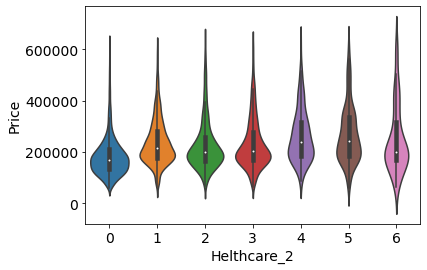

In [26]:
sns.violinplot(train_df.Helthcare_2, train_df.Price)

<AxesSubplot:>

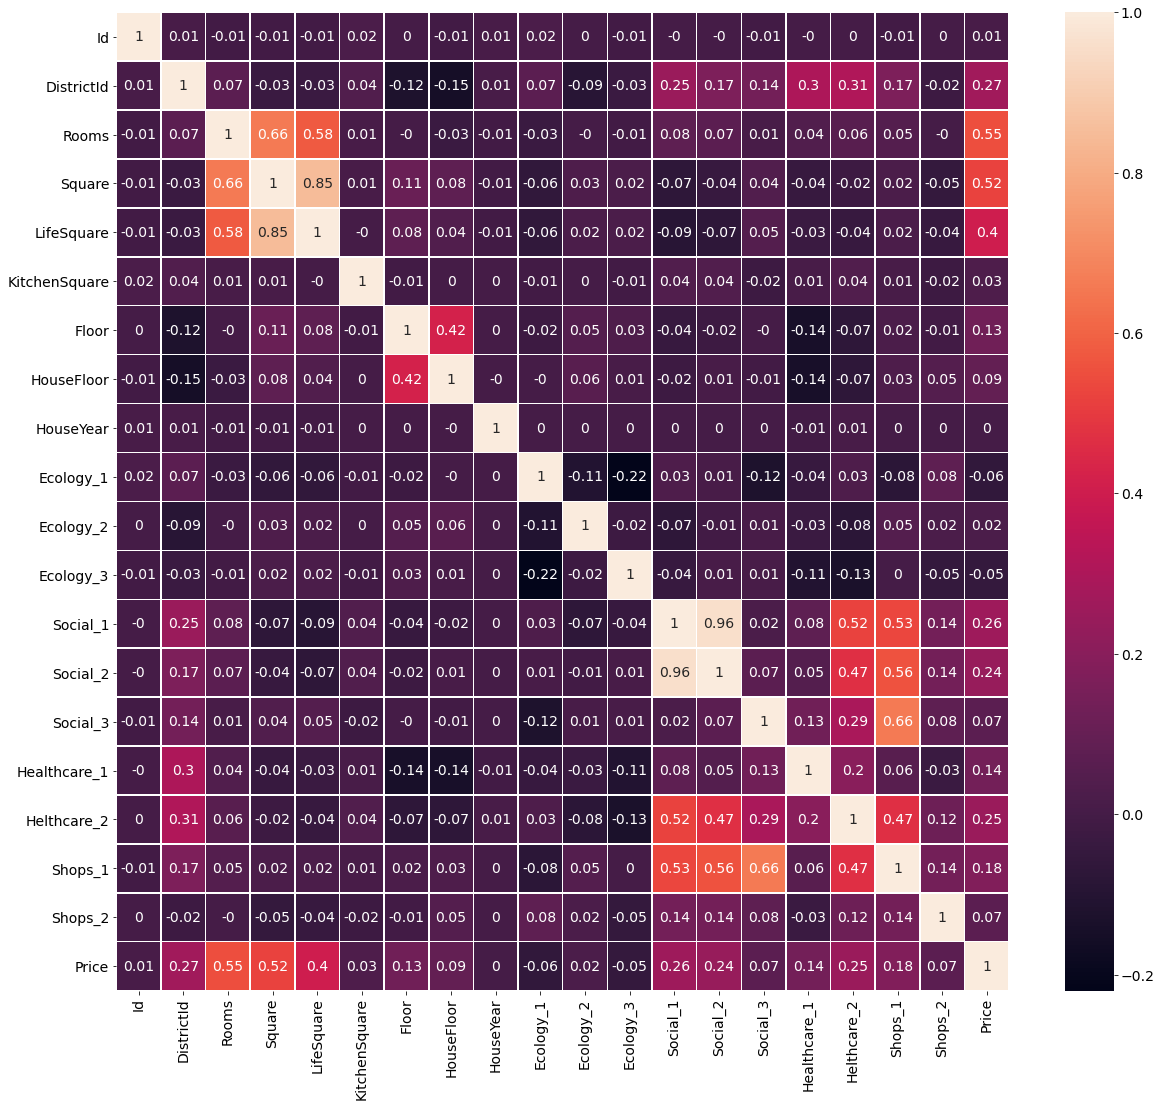

In [27]:
# Матрица корреляций
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 18
sns.heatmap(train_df.corr().round(2), annot=True,linewidths=.5)

In [28]:
# Заполнение пропусков Healthcare_1
def ident_model(train_df):
    model_1 = RandomForestClassifier(max_depth=15)
    train_ = train_df[train_df['Healthcare_1'].isna() == False][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    tr, tst = train_test_split(train_, test_size = 0.15, random_state = 67)
    model_1.fit(tr.drop('Healthcare_1', axis = 1), tr['Healthcare_1'])
    pred = model_1.predict(tst.drop('Healthcare_1', axis = 1))
    print(accuracy_score(tst['Healthcare_1'], pred))
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    model_1.fit(train_.drop('Healthcare_1', axis = 1), train_['Healthcare_1'])
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return model_1


def fill_H1(model_1, train_df):
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1','Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return pred

In [29]:
model_1 = ident_model(train_df)
pred = fill_H1(model_1, train_df)

1.0


In [30]:
# заполняем пропуски в датасете
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = pred

In [31]:
# смотрим, что пропусков нет
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

             name     value
2          Square  0.403310
11       Social_1  0.109159
12       Social_2  0.082479
1           Rooms  0.066536
13       Social_3  0.054418
0      DistrictId  0.040388
8       Ecology_1  0.037736
7       HouseYear  0.035705
14   Healthcare_1  0.033049
3      LifeSquare  0.032975
5           Floor  0.026890
4   KitchenSquare  0.025511
6      HouseFloor  0.023044
16        Shops_1  0.019286
15    Helthcare_2  0.007241
9       Ecology_2  0.000924
17        Shops_2  0.000843
10      Ecology_3  0.000507
[0.7184458453427853, 0.7238751989945909, 0.7240392568991901, 0.7234601261072497, 0.7247061185623698, 0.7228231243535699, 0.7227721829501796, 0.7228605152405555]


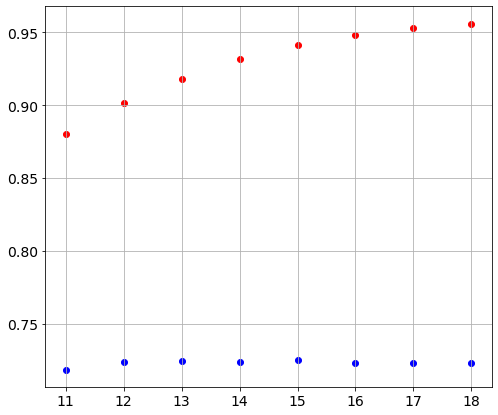

In [32]:
# Со всеми признаками
rcParams['figure.figsize'] = 8, 7

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Id','Price'], axis = 1) , train_df['Price'], test_size = 0.25, random_state = 33 )

r2_train = []
r2_test = []
max_depth = list(range(11,19))
for i in max_depth:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=220)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value' , ascending = False))
print(r2_test)
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
plt.grid(True)

             name     value
2          Square  0.405536
8        Social_1  0.113101
9        Social_2  0.085456
1           Rooms  0.069041
10       Social_3  0.065102
0      DistrictId  0.045351
7       Ecology_1  0.044193
6       HouseYear  0.040297
3      LifeSquare  0.037471
11   Healthcare_1  0.034245
5           Floor  0.031726
4   KitchenSquare  0.028481
[0.7222229467706098, 0.7258823530650793, 0.7277547702775619, 0.7274864230375642, 0.7283688186534891, 0.7267908899645878, 0.7305956748923106, 0.7277261265288661]


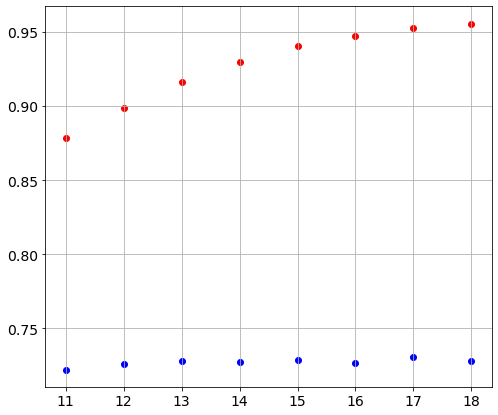

In [33]:
# Удаляем признаки с наименьшей важностью
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Id', 'Ecology_3','HouseFloor','Ecology_2','Shops_1' ,'Shops_2','Helthcare_2' ,'Price'], axis = 1) , train_df['Price'], test_size = 0.25, random_state = 33 )

r2_train = []
r2_test = []
max_depth = list(range(11,19))
for i in max_depth:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=220)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value' , ascending = False))
print(r2_test)
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
plt.grid(True)

#### Создаем новый признак, средней цены на кв. метр по району

In [34]:
train_df['avg_price'] = train_df['Price']/train_df['Square']

In [35]:
mean_by_Did = train_df[['DistrictId','avg_price']].groupby('DistrictId')[['avg_price']].median().reset_index()

In [36]:
mean_by_Did

,DistrictId,avg_price
0,0,3935.906409
1,1,3251.647396
2,2,4550.709250
3,3,3892.203737
4,4,5716.888354
...,...,...
200,202,7447.527733
201,205,5101.016598
202,207,5550.678339
203,208,8005.605047


In [37]:
train_df_ = pd.merge(train_df.drop('avg_price', axis = 'columns'),mean_by_Did, how = 'left', left_on=['DistrictId'], right_on=['DistrictId'])

In [38]:
train_df_.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,avg_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,990.0,0,11,1,184966.930730,4358.274853
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.0,1,16,1,300009.450063,4437.304072
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,34,7759,0,229.0,1,3,1,220925.908524,4845.919064
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.0,0,5,1,175616.227217,2949.975415
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.0,2,4,1,150226.531644,3992.031265


In [39]:
# заменяем HouseFloor
def fill_HouseFloor(train_df):
    train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor'] = train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor']
    return train_df

train_df_ = fill_HouseFloor(train_df_)

In [40]:
#заполняем комнаты
def fill_rooms(train_df):
    train_df.loc[(train_df['Rooms'] > 5) | (train_df['Rooms'] == 0), 'Rooms'] = 5
    return train_df

train_df_ = fill_rooms(train_df_)

In [41]:
train_df[train_df['HouseYear'] >= 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,avg_price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,1,30,6141,10,262.0,3,6,1,254084.534396,6818.302873
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,1,25,4756,16,2857.0,5,8,1,243028.603096,5425.734320


In [42]:
train_df.loc[train_df['HouseYear'] == 20052011,'HouseYear' ] = 2005
train_df.loc[train_df['HouseYear'] == 4968,'HouseYear' ] = 1968

# Возвращаемся к обработке тестового датасета

In [43]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.917600,215869.533082
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,0.275001,79566.438600
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,63712.372456
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,1.000000,165255.489633
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,196137.747776
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,1.000000,249425.932131
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,587232.039597


In [44]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [45]:
test_df = fill_LifeSquare(test_df)

In [46]:
predict_test_H1 = fill_H1(model_1, test_df)
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = predict_test_H1

In [47]:
test_df = fill_HouseFloor(test_df)
test_df = fill_rooms(test_df)

In [48]:
# с признаком avg_price
test_df_ = pd.merge(test_df,mean_by_Did, how = 'left', left_on=['DistrictId'], right_on=['DistrictId'])

In [49]:
test_df_['avg_price'] = test_df_['avg_price'].fillna(test_df_['avg_price'].median())

In [50]:
test_df_.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
avg_price        0
dtype: int64

In [51]:
train_df_.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,avg_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,990.0,0,11,1,184966.930730,4358.274853
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.0,1,16,1,300009.450063,4437.304072
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,34,7759,0,229.0,1,3,1,220925.908524,4845.919064
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.0,0,5,1,175616.227217,2949.975415
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.0,2,4,1,150226.531644,3992.031265


             name     value
2          Square  0.431104
13      avg_price  0.336851
3      LifeSquare  0.029249
7       HouseYear  0.029034
1           Rooms  0.027703
5           Floor  0.022660
6      HouseFloor  0.020846
4   KitchenSquare  0.017180
8       Ecology_1  0.016024
10       Social_2  0.015701
12   Healthcare_1  0.014932
9        Social_1  0.014151
0      DistrictId  0.013004
11       Social_3  0.011561
[0.7383249071774918, 0.7417731988703853, 0.7424634579042556, 0.7422921232751112, 0.7425557126513607, 0.7428886039656576, 0.7398782024635362, 0.7421845819801853]


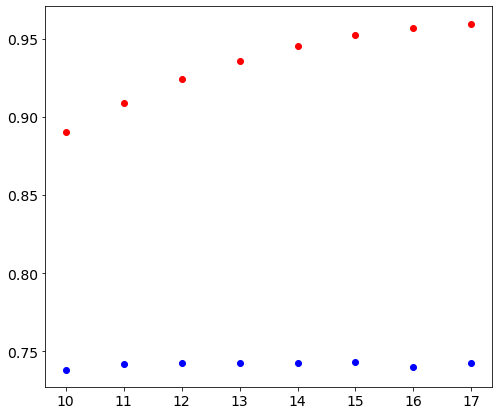

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train_df_.drop(['Id', 'Ecology_3','Ecology_2','Helthcare_2','Shops_1','Shops_2','Price'], axis = 1) , train_df_['Price'], test_size = 0.25, random_state = 31 )

r2_train = []
r2_test = []
max_depth = list(range(10,18))
for i in max_depth:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=220)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value' , ascending = False))
print(r2_test)
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')

### Обучение модели на всех данных и итоговое предсказание

In [53]:
model = RandomForestRegressor(max_depth=15, n_estimators=200)
model.fit(train_df_.drop(['Id', 'Healthcare_1', 'LifeSquare','Price'], axis = 1) , train_df_['Price'] )


RandomForestRegressor(max_depth=15, n_estimators=200)

In [54]:
# Делаем предсказание
itog_predict = model.predict(test_df_.drop(['Id', 'Healthcare_1', 'LifeSquare','Price'], axis = 1))

In [55]:
test_df_['Price'] = itog_predict

In [56]:
test_df_[['Id', 'Price']].to_csv('last_predict.csv', index = False)

In [57]:
imp = pd.DataFrame()
imp['name'] = test_df_.drop(['Id', 'Healthcare_1', 'LifeSquare','Price'], axis = 1).columns
imp['value'] = model.feature_importances_
print(imp.sort_values('value' , ascending = False))

             name     value
2          Square  0.438980
16      avg_price  0.345364
6       HouseYear  0.030601
1           Rooms  0.029838
5      HouseFloor  0.023902
4           Floor  0.022927
3   KitchenSquare  0.020800
7       Ecology_1  0.016268
11       Social_2  0.015829
10       Social_1  0.015105
0      DistrictId  0.013902
12       Social_3  0.010024
14        Shops_1  0.008977
13    Helthcare_2  0.005464
15        Shops_2  0.001049
9       Ecology_3  0.000669
8       Ecology_2  0.000301


In [58]:
test_df[['Id', 'Price']].to_csv('Prediction1.csv', index = False)